In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# built-in statistics functions
from statistics import variance
from scipy.stats import mode

# time series analysis
from statsmodels.tsa import stattools

#plotting
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

Phoenix: 3002

Tuscon: 1011

Portland: 80

San Diego: 1007

Pittsburg: 3001 (best)

In [2]:
# importing data
cols = [3, 5, 8, 13, 18]
ds = pd.read_csv('./pollution_us_2000_2016.csv', header=0, usecols=cols)

ds

,Site Num,State,Date Local,NO2 AQI,O3 AQI
0,3002,Arizona,2000-01-01,46,34
1,3002,Arizona,2000-01-01,46,34
2,3002,Arizona,2000-01-01,46,34
3,3002,Arizona,2000-01-01,46,34
4,3002,Arizona,2000-01-02,34,27
...,...,...,...,...,...
1746656,100,Wyoming,2016-03-30,1,44
1746657,100,Wyoming,2016-03-31,1,44
1746658,100,Wyoming,2016-03-31,1,44
1746659,100,Wyoming,2016-03-31,1,44


In [3]:
t = ['01/2000', '01/2001', '01/2002', '01/2003', '01/2004', '01/2005', '01/2006', '01/2007', '01/2008',
     '01/2009', '01/2010', '01/2011', '01/2012', '01/2013', '01/2014', '01/2015', '01/2016']

In [4]:
# cleaning data

# selecting station in Pittsburg, Pennsylvania
pitts = ds[(ds['Site Num'] == 3001)]

# removing station no., state columns
pitts = pitts.drop(['Site Num', 'State'], axis=1)

# Delete rows with NaNs
pitts = pitts.dropna(axis='rows')

# Change date from string to date value
pitts['Date Local'] = pd.to_datetime(pitts['Date Local'], format='%Y-%m-%d')

pitts

,Date Local,NO2 AQI,O3 AQI
7848,2000-01-01,25,16
7849,2000-01-01,25,16
7850,2000-01-01,25,16
7851,2000-01-01,25,16
7852,2000-01-02,16,19
...,...,...,...
1735754,2016-03-30,35,48
1735755,2016-03-31,11,45
1735756,2016-03-31,11,45
1735757,2016-03-31,11,45


In [5]:
# count NaNs in AQI index cols (sanity check)
print('NO2: ', pitts['NO2 AQI'].isna().sum())
print('O3: ', pitts['O3 AQI'].isna().sum())

NO2:  0
O3:  0


In [6]:
months = np.arange(1,13)
years = np.arange(2000,2016)
nmonths = int(16*12)

NO2means = np.zeros(nmonths)
O3means = np.zeros(nmonths)

j = 0
for YY in years:
    for MM in months:
        NO2means[j] = pitts['NO2 AQI'][(pitts['Date Local'].dt.month==MM)
                                         & (pitts['Date Local'].dt.year==YY)].mean()
        O3means[j] = pitts['O3 AQI'][(pitts['Date Local'].dt.month==MM)
                                         & (pitts['Date Local'].dt.year==YY)].mean()
        
        j += 1

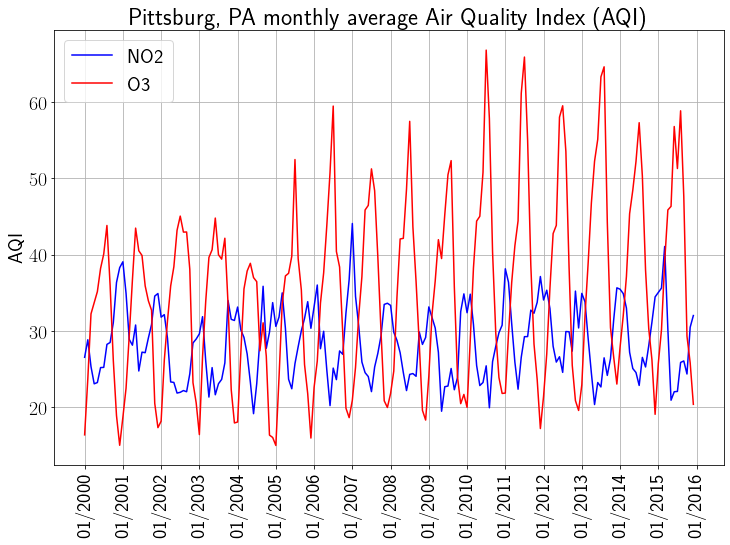

In [7]:
# plotting
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(range(nmonths), NO2means, 'b', label='NO2')
ax.plot(range(nmonths), O3means, 'r', label='O3')
ax.set_ylabel('AQI')
ax.legend(loc='upper left')
ax.set_xticks(np.arange(0,nmonths+12,12))
ax.set_xticklabels(t,rotation='vertical')
ax.set_title('Pittsburg, PA monthly average Air Quality Index (AQI)')
ax.grid()

**Ideas**
1. Propose sinusoidal model for signal, autoregressive model for noise
2. Bayesian inference (ABC) for parameters
3. Credible interval

OR (if all else fails)

1. Fit gamma distribution to summer and winter months
2. Covariance and correlation of time series
3. Hypothesis test (chi-squared against proposed Gamma distribution)

Series = sinusoidal deterministic part + noise?

Model noise first

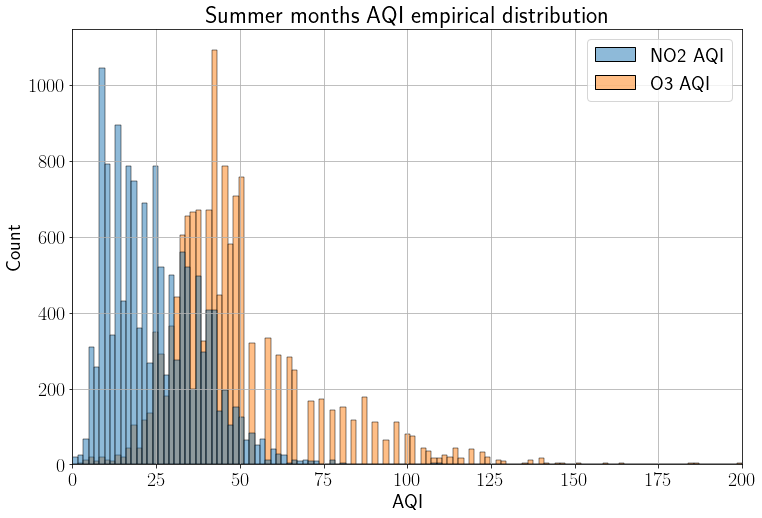

In [8]:
summer = pitts[(pitts['Date Local'].dt.month>5)&(pitts['Date Local'].dt.month<9)]

plt.figure(figsize=(12,8))
sns.histplot(summer)
plt.xlim([0,200])
plt.xlabel('AQI')
plt.title('Summer months AQI empirical distribution')
plt.grid()

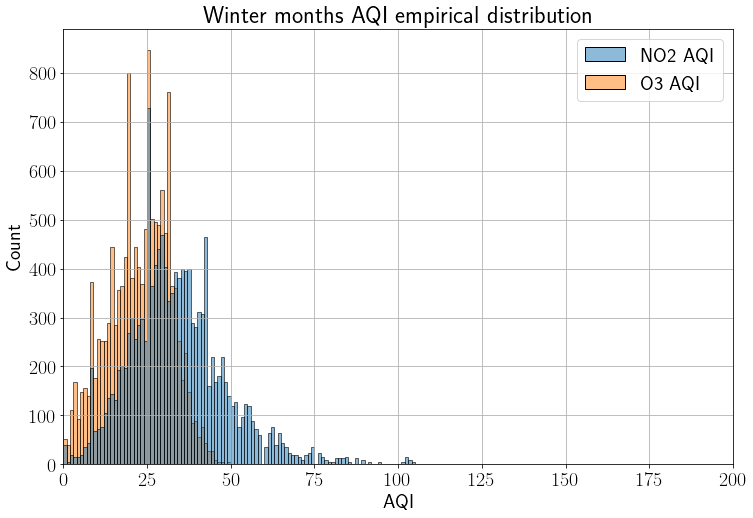

In [9]:
winter = pitts[(pitts['Date Local'].dt.month>11)|(pitts['Date Local'].dt.month<3)]

plt.figure(figsize=(12,8))
sns.histplot(winter)
plt.xlim([0,200])
plt.xlabel('AQI')
plt.title('Winter months AQI empirical distribution')
plt.grid()

Autocovariance

In [10]:
autocovNO2 = stattools.acovf(NO2means)
autocovO3 = stattools.acovf(O3means)

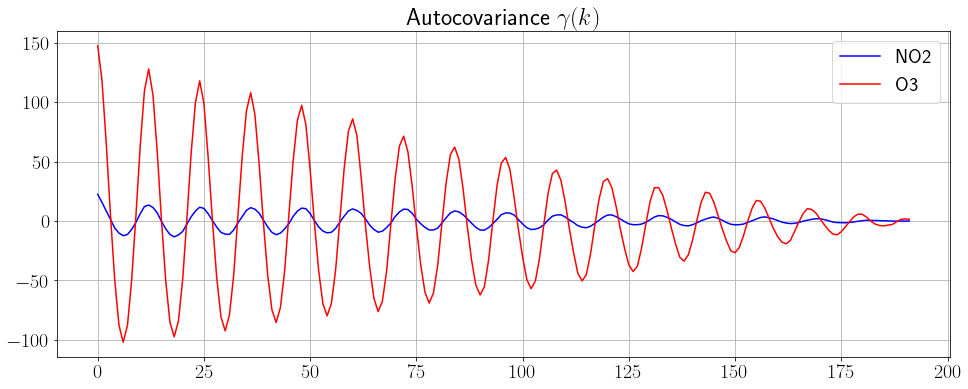

In [11]:
fig = plt.figure(figsize=(16,6))
plt.plot(range(nmonths), autocovNO2, 'b', label='NO2')
plt.plot(range(nmonths), autocovO3, 'r', label='O3')
plt.legend(loc=0)
plt.title('Autocovariance $\gamma (k)$')
plt.grid()

In [12]:
# smooth data
def boxcar_smooth(arr, n):
    newarr = []
    for i in range(n,len(arr)-n):
        newarr += [np.sum(arr[i-n:i+n])/(2*n+1)]
    
    return np.array(newarr)

In [13]:
n = 1
O3means_smooth = boxcar_smooth(O3means, n)
NO2means_smooth = boxcar_smooth(NO2means, n)

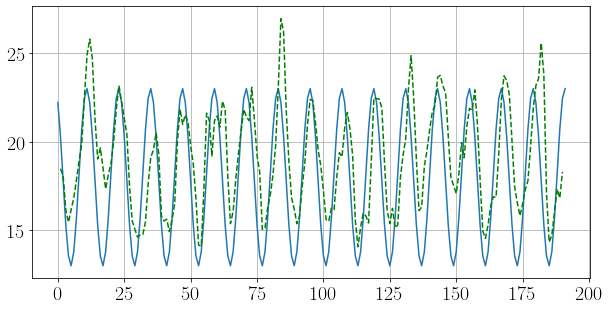

In [14]:
ts = np.arange(0, nmonths)

def signal(a, A, w, e, ts):
    return a - A*np.sin(w*ts + e)

# assume w = 2pi/12 (seasonality) and e = 0 (start at trough)

fig = plt.figure(figsize=(10,5))
plt.plot(ts, signal(18, 5, 2*np.pi/12, -1, ts))
#plt.plot(range(nmonths), O3means, 'r', label='O3')
#plt.plot(range(n,nmonths-n), O3means_smooth, '--g', label='O3')
plt.plot(range(n,nmonths-n), NO2means_smooth, '--g', label='NO2')
plt.grid()

In [15]:
w = 2*np.pi/12

# cost function
def C(a, A, e):
    cost = 0
    for i in range(n,nmonths-n):
        cost += (signal(a, A, w, e, ts[i]) - NO2means_smooth[i-n])**2
    
    return 0.5*cost

# gradient
def gradC(a, A, e):
    cost = np.zeros(3)
    for i in range(n,nmonths-n):
        dcost = signal(a, A, w, e, ts[i]) - NO2means_smooth[i-n]
        cost[0] += dcost
        cost[1] += dcost*(-np.sin(w*ts[i] + e))
        cost[2] += dcost*(-A*np.cos(w*ts[i] + e))
    
    return cost

In [16]:
def gradient_descent(f, df, init, alpha, updates, track_guesses=False, find_max=False):
    # three-parameter gradient descent algorithm with fixed update rule
    current = init
    guesses = np.hstack(( init, C(current[0], current[1], current[2]) ))

    for i in range(updates):
        if find_max == True:
            current += alpha*df(current[0], current[1], current[2])
            
        else:
            current -= alpha*df(current[0], current[1], current[2])
        
        if track_guesses == True:
            guesses = np.vstack(( guesses, np.hstack(( current, C(current[0], current[1], current[2]) )) ))
        
    if track_guesses == True:
        return guesses
    
    else:
        return current

257.1508215781863


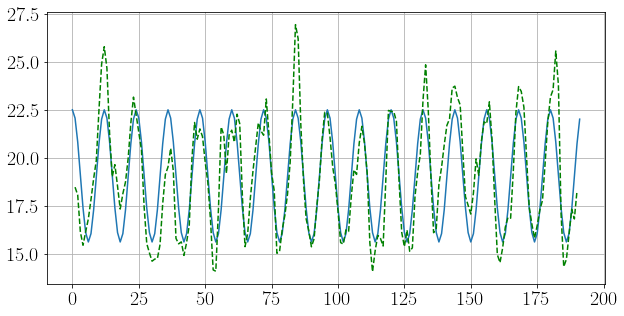

In [17]:
[atrial, Atrial, etrial, Ctrial] = gradient_descent(C, gradC, [18, 5, -1], 0.0001, 2000, track_guesses=True)[-1,:]
print(Ctrial)
fig = plt.figure(figsize=(10,5))
plt.plot(ts, signal(atrial, Atrial, w, etrial, ts))
#plt.plot(range(nmonths), O3means, 'r', label='O3')
#plt.plot(range(n,nmonths-n), O3means_smooth, '--g', label='O3')
plt.plot(range(n,nmonths-n), NO2means_smooth, '--g', label='NO2')
plt.grid()

In [18]:
def noise(phi1, ts):
    W = 0
    for t in range(ts.max()):
        eps = np.random.normal(0, 0.05)
        W = phi1*W + eps
    
    return W

def model(phi1, ts):
    return signal(atrial, Atrial, w, etrial, ts) + noise(phi1, ts)

In [19]:
def chisq_criterion(simdata, realdata):
    measure = 0
    
    for i in range(len(realdata)):
        measure += (simdata[i] - realdata[i])**2/realdata[i]
    
    return measure

In [20]:
tsmooth = ts[1:-1]
chisq_criterion(model(0.9, tsmooth), NO2means_smooth)

26.70779559195946

55150


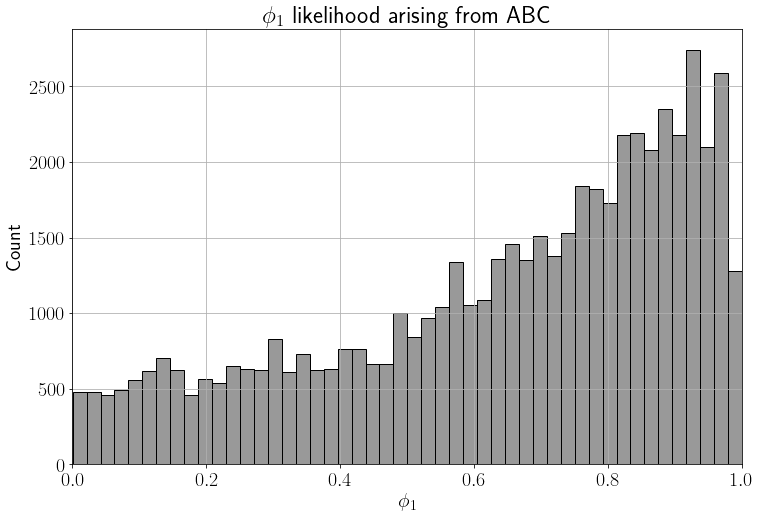

In [21]:
ABC = 5000
Nsim = 150
tol = 26.28
valid_sims = []

for j in range(ABC):

    phitrial = np.random.uniform(0, 1)

    for sims in range(Nsim):
        if chisq_criterion(model(phitrial, tsmooth), NO2means_smooth) < tol:
            valid_sims += [phitrial]

phidist = np.array(valid_sims)
print(len(valid_sims))
fig = plt.figure(figsize=(12,8))

sns.histplot(valid_sims, color='k', alpha=0.4)
plt.xlabel('$\phi_1$')
plt.ylabel('Count')
plt.xlim([0,1])
plt.title('$\phi_1$ likelihood arising from ABC')
plt.grid()

In [22]:
print('Mode: ', mode(phidist))

Mode:  ModeResult(mode=array([0.87746382]), count=array([38]))


In [23]:
phimode = mode(phidist)[0]

In [24]:
# new cost function
def C2(phi1):
    cost = 0
    for i in range(n,nmonths-n):
        cost += (model(phi1, ts[i]) - NO2means_smooth[i-n])**2
    
    return 0.5*cost

C2(phimode)

array([259.33215731])

In [25]:
costdist = []
count = 1000
for i in range(count):
    costdist += [C2(phimode)]

fig = plt.figure(figsize=(12,8))

sns.distplot(costdist, color='b', kde=False)
plt.xlabel('$C(\phi_1)$')
plt.ylabel('Count')
plt.xlim([250,270])
plt.title('C(\phi_1) Empirical Distribution')
plt.grid()

/home/ndoyle/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


RuntimeError: latex was not able to process the following string:
b'C(\\\\phi_1) Empirical Distribution'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../85b8d916f7e391c34e1eea05a3064416.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 85b8d916f7e391c34e1eea05a3064416.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.18 {\sffamily C(\phi
                      _1) Empirical Distribution}
No pages of output.
Transcript written on 85b8d916f7e391c34e1eea05a3064416.log.




<Figure size 864x576 with 1 Axes>

/home/ndoyle/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


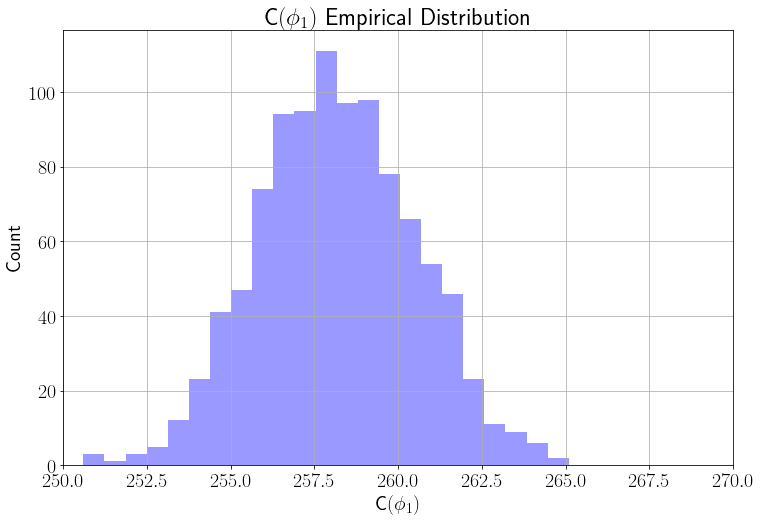

In [28]:
fig = plt.figure(figsize=(12,8))

sns.distplot(costdist, color='b', kde=False)
plt.xlabel('C$(\phi_1)$')
plt.ylabel('Count')
plt.xlim([250,270])
plt.title('C$(\phi_1)$ Empirical Distribution')
plt.grid()